In [0]:
import argparse
import torch
torch.manual_seed(0)
from torch import optim
from torchvision import transforms
import os
import os.path as osp
from PIL import Image
import PIL

ACCESS TO THE DRIVE FOLDER WHERE THE DATASET HAS BEEN STORED

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Final project AIDL/'  #change dir to your project folder

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


DEFINE ARGUMENTS

In [0]:
class Args:

    frontal_images_directories = "gdrive/My Drive/Final project AIDL/dataset-cfp/Protocol/image_list_F.txt"
    profile_images_directories = "gdrive/My Drive/Final project AIDL/dataset-cfp/Protocol/image_list_P.txt"
    split_main_directory = "gdrive/My Drive/Final project AIDL/dataset-cfp/Protocol/Split"
    split_traindata = ["01", "02", "03", "04", "05", "06"]
    split_valdata = ["07", "08"]
    split_testdata = ["09", "10"]
    dataset_root = "gdrive/My Drive/Final project AIDL"
    dataset= "CFPDataset"
    lr = float(5e-4)
    weight_decay = float(0.0005)
    momentum = float(0.9)
    batch_size = int(16)
    workers = int(8)
    start_epoch = int(0)
    epochs = int(20)
    save_every = int(2)
    resume = ""


LOAD DATASET

In [0]:
import numpy as np
import torch
import torchvision
import os.path as osp
from pathlib import Path
from torch.utils.data import dataset
from PIL import Image


class CFPDataset(dataset.Dataset):
    def __init__(self, path, args, img_transforms=None, dataset_root="",
                 split="train", input_size=(224, 224)):
        super().__init__()

        self.data = []
        self.split = split

        self.load(path, args)

        print("Dataset loaded")
        print("{0} samples in the {1} dataset".format(len(self.data),
                                                      self.split))
        self.transforms = img_transforms
        self.dataset_root = dataset_root
        self.input_size = input_size

    def load(self, path, args):

        # read directories for frontal images
        lines = open(args.frontal_images_directories).readlines()
        idx = 0
        directories_frontal_images = []
        while idx < len(lines):
            x = lines[idx].strip().split()
            directories_frontal_images.append(x)
            idx += 1

        # read directories for profile images
        lines = open(args.profile_images_directories).readlines()
        idx = 0
        directories_profile_images = []
        while idx < len(lines):
            x = lines[idx].strip().split()
            directories_profile_images.append(x)
            idx += 1

        # read same and different pairs of images and save at dictionary
        self.data = []
        for i in path:
            ff_diff_file = osp.join(args.split_main_directory, 'FF', i,
                                    'diff.txt')
            lines = open(ff_diff_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                img1_dir = directories_frontal_images[int(img_pair[0])][1]
                img2_dir = directories_frontal_images[int(img_pair[1])][1]
                pair_tag = 0.0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                self.data.append(d)
                idx += 1

            ff_same_file = osp.join(args.split_main_directory, 'FF', i,
                                    'same.txt')
            lines = open(ff_same_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                img1_dir = directories_frontal_images[int(img_pair[0])][1]
                img2_dir = directories_frontal_images[int(img_pair[1])][1]
                pair_tag = 1.0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                self.data.append(d)
                idx += 1

            fp_diff_file = osp.join(args.split_main_directory, 'FP', i,
                                    'diff.txt')
            lines = open(fp_diff_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                img1_dir = directories_frontal_images[int(img_pair[0])][1]
                img2_dir = directories_profile_images[int(img_pair[1])][1]
                pair_tag = 0.0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                self.data.append(d)
                idx += 1

            fp_same_file = osp.join(args.split_main_directory, 'FP', i,
                                    'same.txt')
            lines = open(fp_same_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                img1_dir = directories_frontal_images[int(img_pair[0])][1]
                img2_dir = directories_profile_images[int(img_pair[1])][1]
                pair_tag = 1.0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                self.data.append(d)
                idx += 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data[index]
        image1_path = osp.join(self.dataset_root, 'dataset-cfp', d[
            'img1_path'])
        image2_path = osp.join(self.dataset_root, 'dataset-cfp', d[
            'img2_path'])
        image1 = Image.open(image1_path).convert('RGB')
        image2 = Image.open(image2_path).convert('RGB')
        tag = d['pair_tag']
        if self.transforms is not None:
            # this converts from (HxWxC) to (CxHxW) as wel
            img1 = self.transforms(image1)
            img2 = self.transforms(image2)

        return img1, img2, tag

In [0]:
from torch.utils import data

def get_dataloader(datapath, args, img_transforms=None, split="train"):

    data_loader = data.DataLoader(CFPDataset(datapath,
                                             args,
                                             split=split,
                                             img_transforms=img_transforms,
                                             dataset_root=osp.expanduser(
                                                 args.dataset_root)),
                                  batch_size=args.batch_size,
                                  shuffle=True,    
                                  num_workers=args.workers,
                                  pin_memory=True,
                                  drop_last=True)
    return data_loader

MODEL

In [0]:
import torch
from torch import nn
from torchvision.models import vgg16_bn


class RecognitionModel(nn.Module):
    """
    Siamese network
    """
    def __init__(self):
        super().__init__()

        self.feat = vgg16_bn(pretrained=True).features
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=512*7*7*2, out_features=4096),
            nn.ReLU(True),
            nn.Dropout()
        )
        self.fc2 = nn.Linear(in_features=4096, out_features=2)

    def forward(self, img1, img2):
        # the input to the vgg16 is a fixed-size 224x224 RGB image
        # we get the vgg16 features
        #print(img1.size(), img2.size())
        feat_1 = self.feat(img1)
        feat_2 = self.feat(img2)
        #print(feat_1.size(), feat_2.size())
        feat_1 = feat_1.view(feat_1.size(0), -1)
        feat_2 = feat_2.view(feat_2.size(0), -1)
        #print(feat_1.size(), feat_2.size())
        # we concatenate the two tensors of features
        feat = torch.cat((feat_1, feat_2), 1)
        #print(feat.size())
        # we run the classifier
        feat_3 = self.fc1(feat)
        #print(feat_3.size)
        tag = self.fc2(feat_3)
        #print(tag)
        return tag


LOSS

In [0]:
from torch import nn

class RecognitionCriterion(nn.Module):
    def __init__(self):
        super().__init__()
        self.classification_criterion = nn.CrossEntropyLoss()
        self.cls_loss = None

    def forward(self, *input):
        self.cls_loss = self.classification_criterion(*input)
        return self.cls_loss

TRAINING AND VALIDATION

In [0]:
import torch
from torchvision import transforms
from torch.nn import functional as nnfunc
import numpy as np

def accuracy(predictions, y):
    correct = 0
    total = 0
    preds = torch.topk(predictions, k=1)
    for p, i, label in zip(preds[0], preds[1], y):
        #print(p, i, label)
        total += 1
        if i == 1 and label == 1:
            correct += 1
        if i == 0 and label == 0:
            correct += 1
    return correct/total

def train(model, loss_fn, optimizer, dataloader, epoch, device):
    model = model.to(device)
    model.train()
    all_loss = []
    all_acc = []
        
    for idx, (img1, img2, prob) in enumerate(dataloader):
        x1 = img1.float().to(device)
        x2 = img2.float().to(device)
        optimizer.zero_grad()
        prob_t = prob.to(torch.long)
        #prob_t = prob.type(torch.FloatTensor)
        prob_var = prob_t.to(device)
        #prob_var = prob.to(device)
        #prob_var = prob_var.unsqueeze(dim=1)
        #print(prob_var.size())
        #print(prob_var)
        
        output = model(x1, x2)
        #output = output.reshape(1, -1)
        #output = output.squeeze()
        #print(output.size())
        #print(output)
        
        loss = loss_fn(output, prob_var)
        all_loss.append(loss.item())
        acc = accuracy(output, prob_var)
        all_acc.append(acc) 
        
        loss.backward()
        optimizer.step()
        
            
        if idx % 14 == 0:
            message1 = "TRAIN Epoch [{0}]: [{1}/{2}] ".format(epoch, idx,
                                                              len(dataloader))
            message2 = "Loss: [{0:.4f}]; Accuracy: [{1}]".format(loss.item(),
                                                                acc)
            print(message1, message2)
    
    return all_loss, all_acc

def val(model, loss_fn, dataloader, epoch, device):
    model = model.to(device)
    all_loss = []
    all_acc =[]
    
    for idx, (img1, img2, prob) in enumerate(dataloader):
        x1 = img1.float().to(device)
        x2 = img2.float().to(device)
        
        prob_t = prob.to(torch.long)
        #prob_t = prob.type(torch.FloatTensor)
        prob_var = prob_t.to(device)
        # prob_var = prob.to(device)
        #prob_var = prob_var.unsqueeze(dim=1)
        #print(prob_var.size())
        #print(prob_var)
        output = model(x1, x2)
        #output = output.reshape(1, -1)
        #output = output.squeeze()
        #print(output.size())
        #print(output)
        loss = loss_fn(output, prob_var)
        acc = accuracy(output, prob_var)
        all_loss.append(loss.item())
        all_acc.append(acc)
                
        #print_state(idx, epoch, len(dataloader), loss_fn.cls_loss, split="val")
        if idx % 14 == 0:
            message1 = "VAL Epoch [{0}]: [{1}/{2}] ".format(epoch, idx,
                                                              len(dataloader))
            message2 = "Loss: [{0:.4f}]; Accuracy: [{1}]".format(loss.item(), acc)
            print(message1, message2)
    return all_loss, all_acc

In [0]:
args = Args()
data_aug = True
train_transform=None
if data_aug == False:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

else:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.RandomHorizontalFlip(), 
                                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR), 
                                        transforms.ToTensor()])

img_transforms = train_transform


In [10]:
train_loader = get_dataloader(args.split_traindata, args,
                              img_transforms=img_transforms)

Dataset loaded
8400 samples in the train dataset


In [11]:
val_loader = get_dataloader(args.split_valdata, args,
                            img_transforms=img_transforms, split="val")

Dataset loaded
2800 samples in the val dataset


In [12]:
model = RecognitionModel()
loss_fn = RecognitionCriterion()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:24<00:00, 22524260.99it/s]


In [0]:
# directory where we'll store model weights
weights_dir = "weights"
if not osp.exists(weights_dir):
  
    os.mkdir(weights_dir)

In [14]:
torch.cuda.is_available()

True

In [0]:
# check for CUDA
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [0]:
optimizer = optim.SGD(model.parameters(), lr=args.lr,
                      momentum=args.momentum, weight_decay=args.weight_decay)

In [0]:
#if args.resume:
#    checkpoint = torch.load(args.resume)
#    model.load_state_dict(checkpoint['model'])
#    optimizer.load_state_dict(checkpoint['optimizer'])
#    # Set the start epoch if it has not been
#    if not args.start_epoch:
#        args.start_epoch = checkpoint['epoch']
#
#def save_checkpoint(state, filename="checkpoint.pth", save_path="weights"):
#    # check if the save directory exists
#    if not Path(save_path).exists():
#        Path(save_path).mkdir()
#
#    save_path = Path(save_path, filename)
#    torch.save(state, str(save_path))

In [29]:
!ls

best_epoch.pth.tar  gdrive  sample_data  weights


In [32]:
print(args.epochs)

20


In [0]:
check_point_name = 'best_epoch.pth.tar'
# train and evalute for `epochs`
loss_epoch_train = []
loss_epoch_val = []
acc_epoch_train = []
acc_epoch_val = []
best_acc = 0
for epoch in range(args.start_epoch, args.epochs):
    # scheduler.step()
    train_loss, train_acc = train(model, loss_fn, optimizer, train_loader, epoch, device=device)
    
    av_loss = np.mean(train_loss)
    av_acc = np.mean(train_acc)
    loss_epoch_train.append(av_loss)
    acc_epoch_train.append(av_acc)
    
    #if (epoch + 1) % args.save_every == 0:
    #   save_checkpoint({
    #        'epoch': epoch + 1,
    #        'batch_size': train_loader.batch_size,
    #        'model': model.state_dict(),
    #        'optimizer': optimizer.state_dict()
    #     }, filename="checkpoint_{0}.pth".format(epoch + 1),
    #         save_path=weights_dir)
    
    val_loss, val_acc = val(model, loss_fn, val_loader, epoch, device=device)
    best=max(val_acc)
    if best > best_acc:
        best_acc = best
        best_epoch=epoch
        
        checkpoint = {
            'epoch': epoch,
            'batch_size': train_loader.batch_size,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        
        torch.save(checkpoint, check_point_name)
        torch.save(loss_epoch_train, 'loss_epoch_train')
        torch.save(loss_epoch_val,'loss_epoch_val')
        torch.save(acc_epoch_train,'acc_epoch_train')
        torch.save(acc_epoch_val,'acc_epoch_val')
    
    av_loss = np.mean(val_loss)
    av_acc = np.mean(val_acc)
    loss_epoch_val.append(av_loss)
    acc_epoch_val.append(av_acc)
    
    
print("Best Epoch: ",best_epoch, "Best Acc: ", best_acc)

TRAIN Epoch [0]: [0/525]  Loss: [0.6741]; Accuracy: [0.5]
TRAIN Epoch [0]: [14/525]  Loss: [0.7416]; Accuracy: [0.375]
TRAIN Epoch [0]: [28/525]  Loss: [0.6531]; Accuracy: [0.6875]
TRAIN Epoch [0]: [42/525]  Loss: [0.6228]; Accuracy: [0.6875]
TRAIN Epoch [0]: [56/525]  Loss: [0.6212]; Accuracy: [0.75]
TRAIN Epoch [0]: [70/525]  Loss: [0.7024]; Accuracy: [0.5625]
TRAIN Epoch [0]: [84/525]  Loss: [0.6403]; Accuracy: [0.75]
TRAIN Epoch [0]: [98/525]  Loss: [0.7317]; Accuracy: [0.375]
TRAIN Epoch [0]: [112/525]  Loss: [0.5835]; Accuracy: [0.6875]
TRAIN Epoch [0]: [126/525]  Loss: [0.6725]; Accuracy: [0.5625]
TRAIN Epoch [0]: [140/525]  Loss: [0.6553]; Accuracy: [0.625]
TRAIN Epoch [0]: [154/525]  Loss: [0.6797]; Accuracy: [0.5625]
TRAIN Epoch [0]: [168/525]  Loss: [0.6008]; Accuracy: [0.6875]
TRAIN Epoch [0]: [182/525]  Loss: [0.7259]; Accuracy: [0.4375]
TRAIN Epoch [0]: [196/525]  Loss: [0.6802]; Accuracy: [0.4375]
TRAIN Epoch [0]: [210/525]  Loss: [0.7740]; Accuracy: [0.5625]
TRAIN Epoch

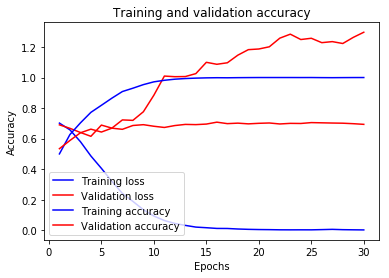

In [0]:
import matplotlib.pyplot as plt
epochs = range(1, len(loss_epoch_train) + 1)
# b is for "solid blue line"
plt.plot(epochs, loss_epoch_train, 'b', label='Training loss')
# r is for "solid red line"
plt.plot(epochs, loss_epoch_val, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('train_val_loss.png')
plt.clf()
plt.show()

epochs = range(1, len(acc_epoch_train) + 1)
# b is for "solid blue line"
plt.plot(epochs, acc_epoch_train, 'b', label='Training accuracy')
# r is for "solid red line"
plt.plot(epochs, acc_epoch_val, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('train_val_acc.png')
plt.show()

In [0]:
cd /content/gdrive/My\ Drive

/content/gdrive/My Drive


In [0]:
cp  -r /content/weights ./

In [0]:
!chmod 777 gdrive Train_val_loss_acc.png